In [41]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cross_validation import train_test_split

Note 1: This notebook is best read with the accompanying explanatory blog post writeup, available at https://www.halleritter.me/blog/2018/7/28/california-motorcycle-accident-statistics-dont-ride-at-night . I have tried to include comments where necessary to understand why I'm doing things, but they're not as good as the full writeup! 

Note 2: This notebook picks up where the data cleaning left off, and includes mostly the modeling portion of the analysis. If you haven't read motorcycle_explore, you may have to pick up some of the feature names as we go (many of which are coded: a guide to these feature codes can be found at https://tims.berkeley.edu/help/SWITRS.php). My philosophy for this notebook is to include all steps that gave me meaningful information about the analysis, even if they're just e.g. calling .isnull().sum().

In [45]:
df = pd.read_pickle('c_driv_d.pkl')

In [50]:
df.isnull().sum()[0:20] #how many nulls are there in columns I care about? Only 50-52. Safe to replace with zero.

CASE_ID_x                   0
PARTY_NUMBER                0
AT_FAULT                    0
PARTY_AGE                   0
ACCIDENT_YEAR               0
COLLISION_DATE              0
COLLISION_TIME              0
DAY_OF_WEEK                 0
NUMBER_KILLED              50
NUMBER_INJURED             52
PARTY_COUNT                 0
PEDESTRIAN_ACCIDENT    199349
BICYCLE_ACCIDENT       199830
MOTORCYCLE_ACCIDENT         0
TRUCK_ACCIDENT         197652
COUNT_MC_KILLED             0
COUNT_MC_INJURED            0
PARTY_SEX_-                 0
PARTY_SEX_F                 0
PARTY_SEX_M                 0
dtype: int64

In [5]:
df.fillna(0, inplace=True)

### Fatalities- Initial Random Forest Model

In [6]:
Xk,yk = df.drop(['COUNT_MC_KILLED', 'COUNT_MC_INJURED', 'NUMBER_INJURED', 'CASE_ID_x', 'NUMBER_KILLED'], axis=1),df['NUMBER_KILLED']

In [7]:
Xk_train, Xk_test, yk_train, yk_test = train_test_split(Xk, yk, test_size=0.3)

In [8]:
rf1k = RandomForestClassifier()

In [9]:
rf1k.fit(Xk_train,yk_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [42]:
nocrossvalscore= rf1k.score(Xk_train,yk_train)
nocrossvalscore #just to check that it's at least training properly

0.99442322329157862

In [15]:
holdoutscore = rf1k.score(Xk_test, yk_test)
holdoutscore

0.9710207468879668

In [16]:
df_k_predict = pd.DataFrame(rf1k.predict(Xk_test))
df_k_predict[0].value_counts() #It's predicting some fatalities, which is good. The concern here is bad class imbalance.

0.0    59721
1.0      528
2.0        1
Name: 0, dtype: int64

In [10]:
k_1_feat = sorted(zip(Xk.columns,abs(rf1k.feature_importances_)), key=lambda x: -x[1])
k_1_feat[0:10]

[('COLLISION_DATE', 0.14474396482515739),
 ('COLLISION_TIME', 0.14183896126630241),
 ('PARTY_AGE', 0.12038682623178483),
 ('ACCIDENT_YEAR', 0.065958662974851395),
 ('PARTY_DRUG_PHYSICAL_E', 0.064231449903224755),
 ('DAY_OF_WEEK', 0.059172324892032377),
 ('PARTY_DRUG_PHYSICAL_-', 0.037162020856763477),
 ('PARTY_COUNT', 0.028358284285293404),
 ('PARTY_NUMBER', 0.015563078546521844),
 ('ALCOHOL_INVOLVED_Y', 0.015290742349086062)]

In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #now in a nice table
pd.DataFrame.from_records(k_1_feat[0:10], columns=['FEATURE', 'VALUE'])

,FEATURE,VALUE
0,COLLISION_DATE,0.145
1,COLLISION_TIME,0.142
2,PARTY_AGE,0.120
3,ACCIDENT_YEAR,0.066
4,PARTY_DRUG_PHYSICAL_E,0.064
5,DAY_OF_WEEK,0.059
6,PARTY_DRUG_PHYSICAL_-,0.037
7,PARTY_COUNT,0.028
8,PARTY_NUMBER,0.016
9,ALCOHOL_INVOLVED_Y,0.015


In [128]:
print(metrics.classification_report(yk_test, rf1k.predict(Xk_test)))

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.99     58209
        1.0       0.76      0.18      0.29      1980
        2.0       0.00      0.00      0.00        59
        5.0       1.00      1.00      1.00         2

avg / total       0.96      0.97      0.96     60250



A little suspicious about collision date, time, and party age being on top of feature importances - see blog writeup for why. Going to try and engineer these features- we don't need date at all, time can turn into hour, and age needs to be cleaned more (on further examination)

### Adding "HOUR" feature; cleaning out "HOUR" and "PARTY_AGE"

In [52]:
df['HOUR'] = np.floor(df.COLLISION_TIME/100)

In [53]:
df.drop(['COLLISION_TIME'], axis=1, inplace=True)

In [54]:
df.loc[df.HOUR==25] ; #this was clearly some coding for "no hour recorded" not mentioned in the documentation - 
#going to figure out how prevalent this is, and whether it would be appropriate to consider them missing data and
#replace with mean or similar

In [257]:
df.HOUR.mean()

13.85329104280671

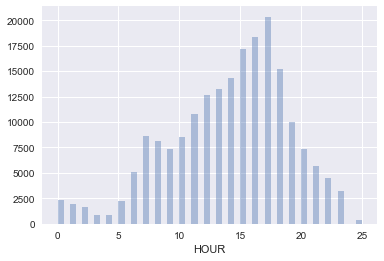

In [259]:
sns.distplot(df.HOUR, kde=False) #there aren't very many 25-hour, comparatively. I think it's safe to replace

In [21]:
df['HOUR'] = df['HOUR'].replace(25, 14)

In [22]:
df.PARTY_AGE.median()

36.0

In [264]:
df.PARTY_AGE.value_counts() #998 is clearly the code for "age unknown". 
#We're dropping entirely any drivers under 12 and above 85, since there's clearly something wrong with those records
#and I'm not sure what (they can't be passengers, because this is filtered on driver), and there's plenty of data.
#although anything <16 or >80ish is also suspect.

22     7119
23     7080
24     6928
21     6713
25     6634
26     6263
998    6017
27     5957
28     5635
20     5631
29     5177
30     4971
31     4724
32     4472
33     4284
19     4221
34     4045
35     3980
36     3851
38     3777
37     3745
47     3739
43     3719
40     3703
46     3674
44     3638
45     3599
42     3596
48     3589
39     3582
       ... 
85       42
83       41
7        38
82       34
84       28
6        26
86       25
87       17
88       16
5        15
89       14
100      13
91       11
99       11
92       10
0         9
90        7
96        7
93        5
101       5
95        4
98        4
97        3
4         3
3         2
2         2
104       2
94        1
102       1
1         1
Name: PARTY_AGE, dtype: int64

In [23]:
df_agecorr = df.drop(df[(df.PARTY_AGE<12)|((df.PARTY_AGE>85)&(df.PARTY_AGE!=998))].index)

In [276]:
df_agecorr.PARTY_AGE.median()

36.0

In [24]:
df_agecorr['PARTY_AGE'] = df_agecorr['PARTY_AGE'].replace(998, 36) #replacing the "age unknown" code w/ median

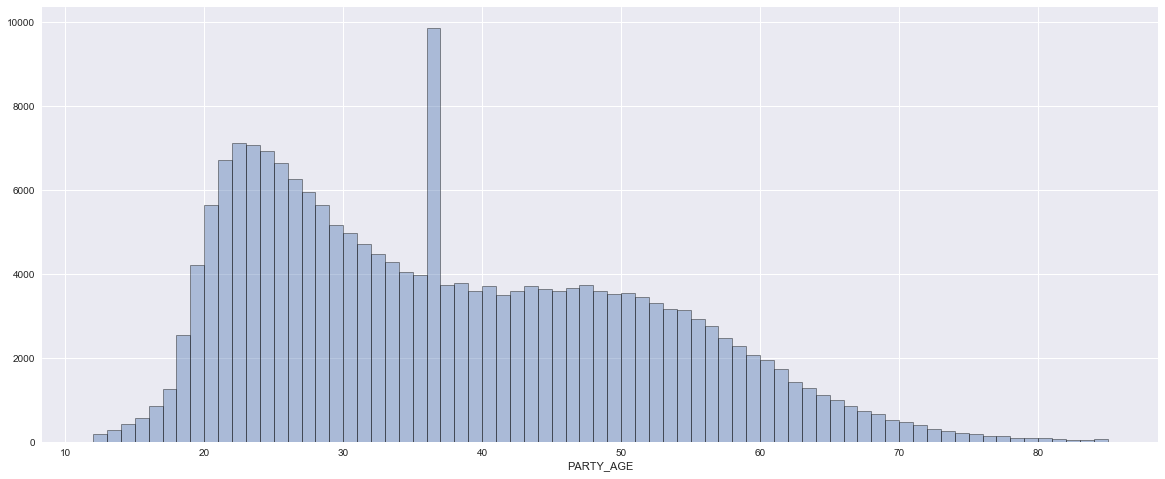

In [284]:
plt.figure(figsize=(20,8))
sns.distplot(df_agecorr.PARTY_AGE, bins=73, kde=False, hist_kws=dict(edgecolor="k", linewidth=1))

### Predict Unsafe User Behavior- Initial Random Forest Model

In [293]:
cols = ['PARTY_AGE',
       'ACCIDENT_YEAR', 'HOUR', 'DAY_OF_WEEK',
       'NUMBER_KILLED', 'NUMBER_INJURED', 'PARTY_COUNT',
       'PEDESTRIAN_ACCIDENT', 'BICYCLE_ACCIDENT', 'MOTORCYCLE_ACCIDENT',
       'TRUCK_ACCIDENT', 'COUNT_MC_KILLED', 'COUNT_MC_INJURED',
       'PARTY_SEX_-', 'PARTY_SEX_F', 'PARTY_SEX_M', 'PARTY_SOBRIETY_-',
       'PARTY_SOBRIETY_A', 'PARTY_SOBRIETY_B', 'PARTY_SOBRIETY_C',
       'PARTY_SOBRIETY_D', 'PARTY_SOBRIETY_G', 'PARTY_SOBRIETY_H',
       'PARTY_DRUG_PHYSICAL_-', 'PARTY_DRUG_PHYSICAL_E',
       'PARTY_DRUG_PHYSICAL_F', 'PARTY_DRUG_PHYSICAL_G',
       'PARTY_DRUG_PHYSICAL_H', 'PARTY_DRUG_PHYSICAL_I', 'ALCOHOL_INVOLVED_Y', 'SP_INFO_2_-',
       'SP_INFO_2_1', 'SP_INFO_2_2', 'SP_INFO_2_3', 'SP_INFO_2_B',
       'SP_INFO_2_C', 'SP_INFO_2_D', 'OAF_VIOL_CAT_- ', 'OAF_VIOL_CAT_00',
       'OAF_VIOL_CAT_19', 'OAF_VIOL_CAT_20', 'OAF_VIOL_CAT_21',
       'OAF_VIOL_CAT_22', 'OAF_VIOL_CAT_23', 'OAF_VIOL_CAT_24',
       'OAF_VIOL_CAT_25', 'OAF_VIOL_CAT_26', 'OAF_VIOL_CAT_27',
       'OAF_VIOL_CAT_28', 'OAF_VIOL_CAT_29', 'OAF_VIOL_CAT_30',
       'OAF_VIOL_CAT_31', 'OAF_VIOL_CAT_33', 'OAF_VIOL_CAT_34',
       'OAF_VIOL_CAT_35', 'OAF_VIOL_CAT_38', 'OAF_VIOL_CAT_39',
       'OAF_VIOL_CAT_40', 'OAF_VIOL_CAT_43', 'OAF_VIOL_CAT_44',
       'OAF_VIOL_CAT_46', 'OAF_VIOL_CAT_47', 'OAF_VIOL_CAT_51',
       'OAF_VIOL_CAT_53', 'OAF_VIOL_CAT_60'] #these are the columns that seem like they might have some bearing on
#safety-related user behavior (e.g. taking things out like road surface, weather, etc.)

In [294]:
Xhat,yhat = df_agecorr[cols],df_agecorr['PARTY_SAFETY_EQUIP_2_V']

In [295]:
Xh_train, Xh_test, yh_train, yh_test = train_test_split(Xhat, yhat, test_size=0.3)

In [296]:
rf1h = RandomForestClassifier()

In [297]:
rf1h.fit(Xh_train,yh_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [298]:
nocrossvalscore= rf1h.score(Xh_train,yh_train)
nocrossvalscore

0.99240807997202973

In [299]:
holdoutscore = rf1h.score(Xh_test, yh_test)
holdoutscore

0.97048197785732127

In [300]:
df_hat_predict = pd.DataFrame(rf1h.predict(Xh_test))
df_hat_predict[0].value_counts() #it is predicting some of class 1, although not quite the same proportion as 
#are present in the dataset

0    59794
1      271
Name: 0, dtype: int64

In [301]:
df.PARTY_SAFETY_EQUIP_2_V.value_counts()

0    195597
1      5236
Name: PARTY_SAFETY_EQUIP_2_V, dtype: int64

In [302]:
print(metrics.classification_report(yh_test, rf1h.predict(Xh_test))) #class imbalance problem

             precision    recall  f1-score   support

          0       0.97      1.00      0.99     58485
          1       0.14      0.02      0.04      1580

avg / total       0.95      0.97      0.96     60065



In [303]:
sorted(zip(Xhat.columns,abs(rf1h.feature_importances_)), key=lambda x: -x[1])

[('PARTY_AGE', 0.32823776524803561),
 ('HOUR', 0.20643254781617956),
 ('ACCIDENT_YEAR', 0.17501094902417449),
 ('DAY_OF_WEEK', 0.11583036433238085),
 ('PARTY_COUNT', 0.030135605481785149),
 ('NUMBER_INJURED', 0.019291533955971753),
 ('COUNT_MC_INJURED', 0.015199772812682422),
 ('SP_INFO_2_3', 0.0085322910503074102),
 ('OAF_VIOL_CAT_25', 0.0061509354014725468),
 ('OAF_VIOL_CAT_- ', 0.0059876155052730265),
 ('PARTY_SEX_M', 0.0056289823381223906),
 ('PARTY_SOBRIETY_A', 0.0052750420185857065),
 ('PARTY_SOBRIETY_B', 0.0049336047844214786),
 ('ALCOHOL_INVOLVED_Y', 0.0047871323101680938),
 ('PARTY_SEX_F', 0.0047153914704937943),
 ('SP_INFO_2_-', 0.0043467152126082402),
 ('OAF_VIOL_CAT_31', 0.004321204123746477),
 ('NUMBER_KILLED', 0.0036472724174096706),
 ('COUNT_MC_KILLED', 0.0036140110521262203),
 ('OAF_VIOL_CAT_44', 0.0035930830234275702),
 ('TRUCK_ACCIDENT', 0.0030443162312729461),
 ('OAF_VIOL_CAT_27', 0.0029572689936673692),
 ('PARTY_DRUG_PHYSICAL_-', 0.0028539248233766475),
 ('PEDESTRIA

[<matplotlib.text.Text at 0x1a2e97390>, <matplotlib.text.Text at 0x1a2e43c50>]

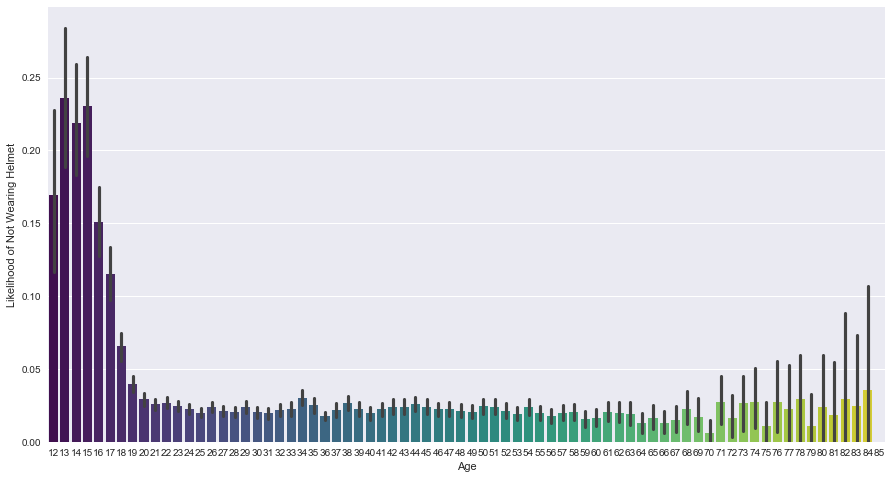

In [414]:
plt.figure(figsize=(15,8))
ax = sns.barplot(y=df_agecorr.PARTY_SAFETY_EQUIP_2_V, x=df_agecorr.PARTY_AGE, palette='viridis')
ax.set(xlabel='Age', ylabel='Likelihood of Not Wearing Helmet') #a visualization of the "party age" feature

[<matplotlib.text.Text at 0x13feb7550>, <matplotlib.text.Text at 0x1878f0128>]

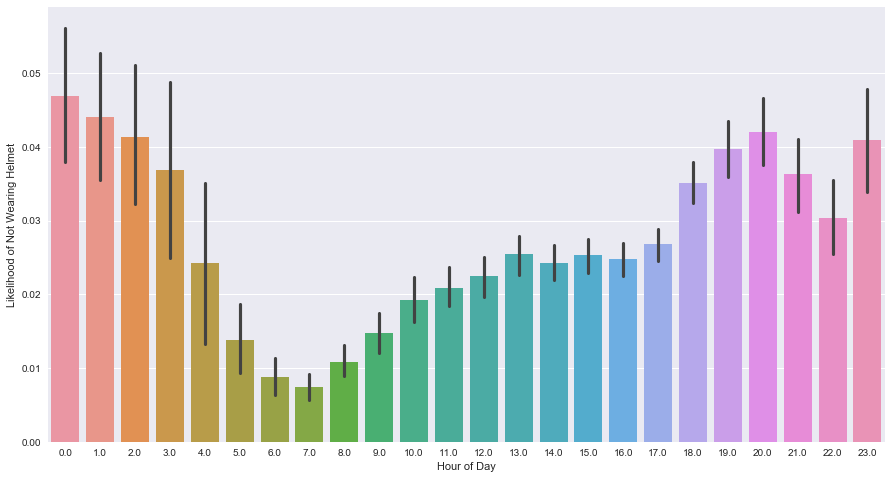

In [415]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=df_agecorr.HOUR, y=df_agecorr.PARTY_SAFETY_EQUIP_2_V)
ax.set(xlabel='Hour of Day', ylabel='Likelihood of Not Wearing Helmet')

### Fatalities model again, this time with the new, better hour and age features

In [25]:
X1k,y1k = df_agecorr.drop(['COUNT_MC_KILLED', 'COUNT_MC_INJURED', 'NUMBER_INJURED', 'CASE_ID_x', 'NUMBER_KILLED', 'COLLISION_DATE'], axis=1),df_agecorr['NUMBER_KILLED']

In [26]:
Xk1_train, Xk1_test, yk1_train, yk1_test = train_test_split(X1k, y1k, test_size=0.3)

In [27]:
rf2k = RandomForestClassifier()

In [28]:
rf2k.fit(Xk1_train,yk1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [450]:
nocrossvalscore= rf2k.score(Xk1_train,yk1_train)
nocrossvalscore

0.99400637892528665

In [451]:
holdoutscore = rf2k.score(Xk1_test, yk1_test)
holdoutscore

0.97001581619911759

In [29]:
k_2_feat = sorted(zip(X1k.columns,abs(rf2k.feature_importances_)), key=lambda x: -x[1])
k_2_feat[0:10]

[('PARTY_AGE', 0.17605190368825357),
 ('HOUR', 0.12553567826344572),
 ('ACCIDENT_YEAR', 0.10896346577191481),
 ('PARTY_DRUG_PHYSICAL_E', 0.094936502740161688),
 ('DAY_OF_WEEK', 0.076919285160799142),
 ('PARTY_COUNT', 0.033578789911182752),
 ('PARTY_DRUG_PHYSICAL_-', 0.025617888627105255),
 ('PARTY_NUMBER', 0.016937882315676434),
 ('PARTY_SOBRIETY_A', 0.016211171589806318),
 ('AT_FAULT', 0.013936760826984923)]

In [31]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.DataFrame.from_records(k_2_feat[0:10], columns=['FEATURE', 'VALUE'])

,FEATURE,VALUE
0,PARTY_AGE,0.176
1,HOUR,0.126
2,ACCIDENT_YEAR,0.109
3,PARTY_DRUG_PHYSICAL_E,0.095
4,DAY_OF_WEEK,0.077
5,PARTY_COUNT,0.034
6,PARTY_DRUG_PHYSICAL_-,0.026
7,PARTY_NUMBER,0.017
8,PARTY_SOBRIETY_A,0.016
9,AT_FAULT,0.014


In [324]:
df_2k_predict = pd.DataFrame(rf2k.predict(Xk1_test))
df_2k_predict[0].value_counts()

0.0    59457
1.0      606
2.0        2
Name: 0, dtype: int64

In [32]:
df_agecorr.NUMBER_KILLED.value_counts() #this true percentage from the data is actually fairly close to the 
#predicted values above- class imbalance may not be too bad (or at least not just predicting false negatives)

0.000    193427
1.000      6600
2.000       174
5.000         6
3.000         6
4.000         1
Name: NUMBER_KILLED, dtype: int64

In [292]:
print(metrics.classification_report(yk1_test, rf2k.predict(Xk1_test))) #nevermind, that's not great

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98     58014
        1.0       0.68      0.21      0.32      1992
        2.0       0.50      0.02      0.04        54
        3.0       0.00      0.00      0.00         1
        5.0       0.00      0.00      0.00         4

avg / total       0.96      0.97      0.96     60065



/Users/hritter/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[<matplotlib.text.Text at 0x187697d68>, <matplotlib.text.Text at 0x177ec6d30>]

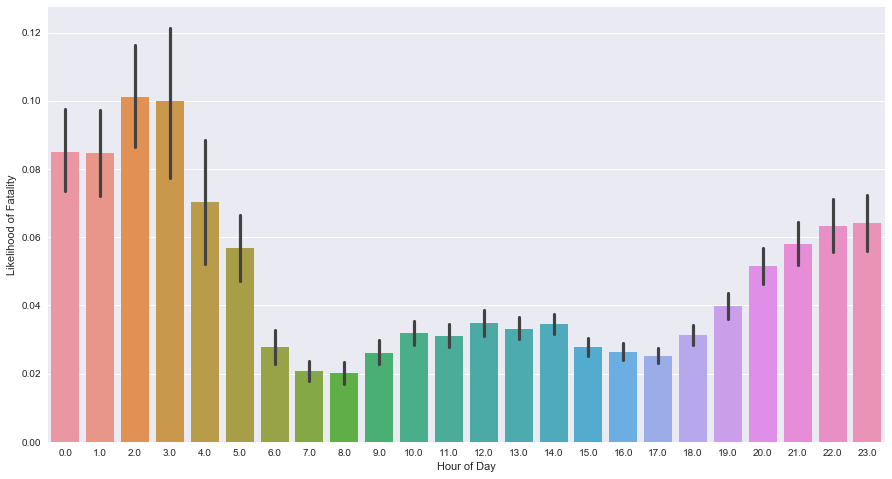

In [400]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=df_agecorr.HOUR, y=df_agecorr.NUMBER_KILLED)
ax.set(xlabel='Hour of Day', ylabel='Likelihood of Fatality')

(0, 0.15)

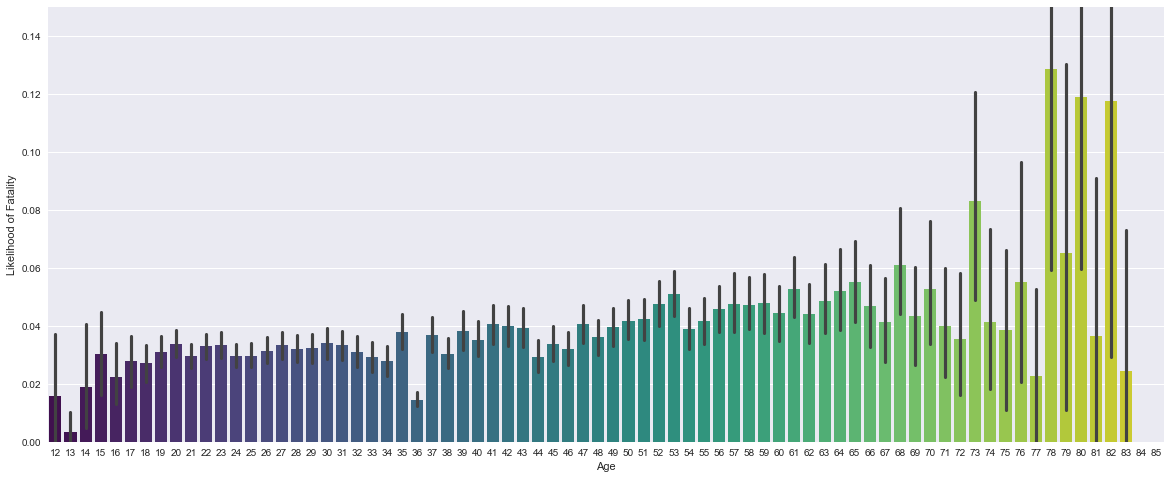

In [401]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=df_agecorr.PARTY_AGE, y=df_agecorr.NUMBER_KILLED, palette='viridis')
ax.set(xlabel='Age', ylabel='Likelihood of Fatality')
sns.plt.ylim(0, 0.15)

### Check whether age is important because of bin count:

In [33]:
#as mentioned above, suspicion that high-bin count variables may be overweighted in the feature importances list
#because of the way scikit-learn calculates feature importance based on Gini importance. See blog writeup. The best
#way to make sure is to make a new model dropping those features, and then see how much predictive power it loses.

In [318]:
X2k,y2k = df_agecorr.drop(['COUNT_MC_KILLED', 'COUNT_MC_INJURED', 'NUMBER_INJURED', 'CASE_ID_x', 'NUMBER_KILLED', 'COLLISION_DATE', 'PARTY_AGE'], axis=1),df_agecorr['NUMBER_KILLED']

In [319]:
X2k_train, X2k_test, y2k_train, y2k_test = train_test_split(X2k, y2k, test_size=0.3)

In [320]:
rf3k = RandomForestClassifier()

In [321]:
rf3k.fit(X2k_train,y2k_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [322]:
nocrossvalscore= rf3k.score(X2k_train,y2k_train)
nocrossvalscore

0.99045301785956374

In [323]:
holdoutscore = rf3k.score(X2k_test, y2k_test)
holdoutscore

0.96875052026970787

In [333]:
print(metrics.classification_report(y2k_test, rf3k.predict(X2k_test)))

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98     58057
        1.0       0.58      0.22      0.32      1962
        2.0       0.12      0.02      0.04        44
        3.0       0.00      0.00      0.00         1
        5.0       1.00      1.00      1.00         1

avg / total       0.96      0.97      0.96     60065



/Users/hritter/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#class 1 precision goes from 0.68 to 0.58 in age-dropped model - clearly somewhat important

### Check whether hour is important because of bin count:

In [35]:
X3k,y3k = df_agecorr.drop(['COUNT_MC_KILLED', 'COUNT_MC_INJURED', 'NUMBER_INJURED', 'CASE_ID_x', 'NUMBER_KILLED', 'COLLISION_DATE', 'HOUR'], axis=1),df_agecorr['NUMBER_KILLED']

In [36]:
X3k_train, X3k_test, y3k_train, y3k_test = train_test_split(X3k, y3k, test_size=0.3)

In [37]:
rf4k = RandomForestClassifier()

In [38]:
rf4k.fit(X3k_train,y3k_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [330]:
nocrossvalscore= rf4k.score(X3k_train,y3k_train)
nocrossvalscore

0.99210839891829405

In [332]:
holdoutscore = rf4k.score(X3k_test, y3k_test)
holdoutscore

0.96838425039540499

In [39]:
print(metrics.classification_report(y3k_test, rf4k.predict(X3k_test))) #model precision declines 
#substantially and recall slightly compared to model with both in it, more so than taking age out,
#even though age was considered the "more important" feature - indicating that the "feature importances"
#may have in fact been assigning a higher score due to there being lots of categorical bins; however, both features
#are clearly still important

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98     58056
        1.0       0.57      0.20      0.30      1953
        2.0       0.20      0.02      0.03        54
        3.0       0.00      0.00      0.00         1
        5.0       1.00      1.00      1.00         1

avg / total       0.96      0.97      0.96     60065



/Users/hritter/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 50-50 class split model for helmets

In [40]:
#as noted above, there is a class imbalance problem. One way to get a model with higher recall is to rebalance
#the classes so the model trains on more of the smaller class.

In [348]:
df_agecorr.PARTY_SAFETY_EQUIP_2_V.value_counts()

0    195060
1      5154
Name: PARTY_SAFETY_EQUIP_2_V, dtype: int64

In [350]:
H_indices = df_agecorr[df_agecorr.PARTY_SAFETY_EQUIP_2_V == 0].index #creating 50-50 sample
random_indices = np.random.choice(H_indices, 5154, replace=False)
H_sample = df_agecorr.loc[random_indices]

In [351]:
NH_indices = df_agecorr[df_agecorr.PARTY_SAFETY_EQUIP_2_V == 1].index
NH_sample = df_agecorr.loc[NH_indices]

In [352]:
for_model = H_sample.append(NH_sample)

In [354]:
Xhat1,yhat1 = for_model[cols],for_model['PARTY_SAFETY_EQUIP_2_V']

In [355]:
Xhat1_train, Xhat1_test, yhat1_train, yhat1_test = train_test_split(Xhat1, yhat1, test_size=0.3)

In [356]:
rf5 = RandomForestClassifier()

In [357]:
rf5.fit(Xhat1_train,yhat1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [358]:
nocrossvalscore= rf5.score(Xhat1_train,yhat1_train)
nocrossvalscore

0.98059598059598063

In [359]:
holdoutscore = rf5.score(Xhat1_test, yhat1_test)
holdoutscore

0.66117038473973488

In [360]:
print(metrics.classification_report(yhat1_test, rf5.predict(Xhat1_test))) #this is much more balanced

             precision    recall  f1-score   support

          0       0.64      0.72      0.68      1526
          1       0.69      0.60      0.64      1567

avg / total       0.66      0.66      0.66      3093



In [361]:
sorted(zip(Xhat1.columns,abs(rf5.feature_importances_)), key=lambda x: -x[1])

[('PARTY_AGE', 0.26797391096427498),
 ('ACCIDENT_YEAR', 0.18817250507963723),
 ('HOUR', 0.17009615325053848),
 ('DAY_OF_WEEK', 0.094922891363407536),
 ('PARTY_COUNT', 0.038951298215926244),
 ('PARTY_SOBRIETY_A', 0.027914706165872522),
 ('NUMBER_INJURED', 0.022279007840084086),
 ('COUNT_MC_INJURED', 0.019888440038335647),
 ('SP_INFO_2_3', 0.01863649852925512),
 ('OAF_VIOL_CAT_- ', 0.0164643288281765),
 ('PARTY_SOBRIETY_B', 0.016068992600281821),
 ('ALCOHOL_INVOLVED_Y', 0.011848887277022654),
 ('SP_INFO_2_D', 0.01109178265334137),
 ('SP_INFO_2_C', 0.0093973717429787045),
 ('PARTY_SEX_M', 0.0073167204840010767),
 ('SP_INFO_2_-', 0.0065694981574035485),
 ('COUNT_MC_KILLED', 0.0055352939933328666),
 ('PARTY_SEX_F', 0.005357228331897607),
 ('OAF_VIOL_CAT_25', 0.0051177980267760031),
 ('NUMBER_KILLED', 0.0046546277998519205),
 ('OAF_VIOL_CAT_31', 0.0046237814993573762),
 ('TRUCK_ACCIDENT', 0.0043877790806520506),
 ('OAF_VIOL_CAT_44', 0.0032076059232145843),
 ('PARTY_SEX_-', 0.0031673281459144

[<matplotlib.text.Text at 0x1780fe6a0>, <matplotlib.text.Text at 0x1a2ec4780>]

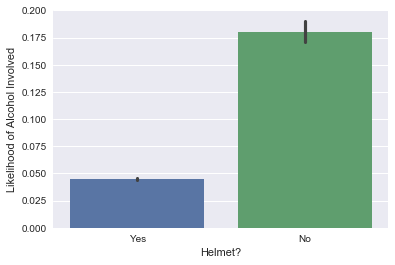

In [416]:
ax = sns.barplot(x=df_agecorr.PARTY_SAFETY_EQUIP_2_V, y=df_agecorr.PARTY_SOBRIETY_B)
ax.set(xlabel='Helmet?', ylabel='Likelihood of Alcohol Involved')
ax.set_xticklabels(['Yes', 'No'])

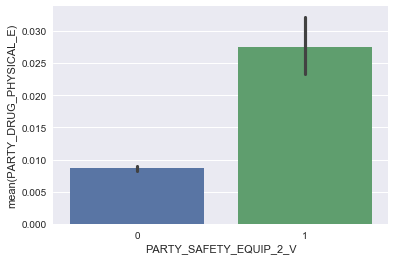

In [412]:
sns.barplot(x=df_agecorr.PARTY_SAFETY_EQUIP_2_V, y=df_agecorr.PARTY_DRUG_PHYSICAL_E)
ax.set(xlabel='Helmet?', ylabel='Likelihood of Not Wearing Helmet')
ax.set_xticklabels(['Yes', 'No'])

[<matplotlib.text.Text at 0x1780b0a58>, <matplotlib.text.Text at 0x1a0e89b38>]

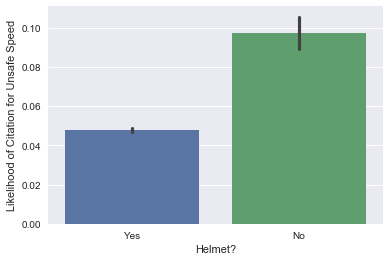

In [418]:
ax= sns.barplot(x=df_agecorr.PARTY_SAFETY_EQUIP_2_V, y=df_agecorr.OAF_VIOL_CAT_25)
ax.set(xlabel='Helmet?', ylabel='Likelihood of Citation for Unsafe Speed')
ax.set_xticklabels(['Yes', 'No'])

### 50-50 class split model for fatalities

In [376]:
df_agecorr.NUMBER_KILLED.value_counts()

0.0    193427
1.0      6600
2.0       174
5.0         6
3.0         6
4.0         1
Name: NUMBER_KILLED, dtype: int64

In [389]:
NK_indices = df_agecorr[df_agecorr.NUMBER_KILLED == 0].index
random_indices = np.random.choice(NK_indices, 6600, replace=False)
NK_sample = df_agecorr.loc[random_indices]

In [390]:
K_indices = df_agecorr[df_agecorr.NUMBER_KILLED == 1].index
K_sample = df_agecorr.loc[K_indices]

In [391]:
for_model2 = NK_sample.append(K_sample)

In [392]:
Xkp,ykp = for_model2.drop(['COUNT_MC_KILLED', 'COUNT_MC_INJURED', 'NUMBER_INJURED', 'CASE_ID_x', 'NUMBER_KILLED', 'COLLISION_DATE'], axis=1),for_model2['NUMBER_KILLED']

In [393]:
Xkp_train, Xkp_test, ykp_train, ykp_test = train_test_split(Xkp, ykp, test_size=0.3)

In [394]:
rf6 = RandomForestClassifier()

In [395]:
rf6.fit(Xkp_train,ykp_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [396]:
nocrossvalscore= rf6.score(Xkp_train,ykp_train)
nocrossvalscore

0.98452380952380958

In [397]:
holdoutscore = rf6.score(Xkp_test, ykp_test)
holdoutscore

0.74191919191919187

In [398]:
print(metrics.classification_report(ykp_test, rf6.predict(Xkp_test))) #again, much more balanced

             precision    recall  f1-score   support

        0.0       0.72      0.79      0.76      1990
        1.0       0.77      0.69      0.73      1970

avg / total       0.74      0.74      0.74      3960



In [399]:
sorted(zip(Xkp.columns,abs(rf6.feature_importances_)), key=lambda x: -x[1])

[('PARTY_AGE', 0.13034564425363718),
 ('HOUR', 0.10216883954347837),
 ('ACCIDENT_YEAR', 0.090215141441094202),
 ('DAY_OF_WEEK', 0.067593744083343316),
 ('PARTY_DRUG_PHYSICAL_-', 0.052022389157171112),
 ('PARTY_DRUG_PHYSICAL_E', 0.045555105828757748),
 ('PARTY_SOBRIETY_A', 0.039740277010003731),
 ('OAF_VIOL_CAT_- ', 0.030751785087200806),
 ('PARTY_COUNT', 0.027419204978596436),
 ('PARTY_NUMBER', 0.018642263378822528),
 ('ALCOHOL_INVOLVED_Y', 0.018469638845566867),
 ('MVIW_I', 0.018449234244824222),
 ('AT_FAULT', 0.015900842794819355),
 ('TRUCK_ACCIDENT', 0.01430899593035603),
 ('PARTY_SOBRIETY_B', 0.013858177638701416),
 ('LIGHTING_A', 0.012845858949300501),
 ('PARTY_DRUG_PHYSICAL_G', 0.012034057677667759),
 ('PARTY_SAFETY_EQUIP_2_W', 0.011962500474685268),
 ('OAF_VIOL_CAT_25', 0.011378911334473434),
 ('LIGHTING_D', 0.010540730020270074),
 ('SP_INFO_2_-', 0.010392868656287241),
 ('MVIW_C', 0.010243832323292609),
 ('PARTY_SOBRIETY_G', 0.010005169522775656),
 ('PARTY_SAFETY_EQUIP_1_P', 0.

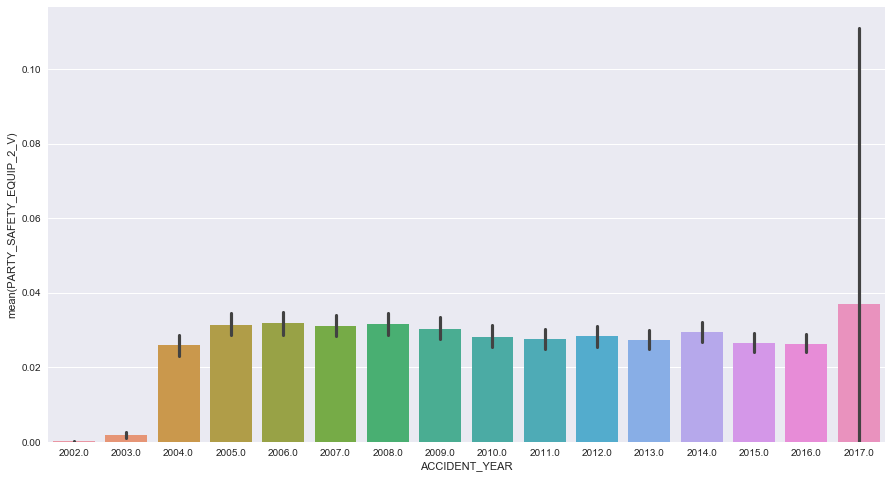

In [363]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=df_agecorr.ACCIDENT_YEAR, y=df_agecorr.PARTY_SAFETY_EQUIP_2_V) 
#clearly they just started coding this feature in 2004; that isn't very useful or important despite showing up high
#in the feature importances

[<matplotlib.text.Text at 0x1a33772e8>, <matplotlib.text.Text at 0x1876fac18>]

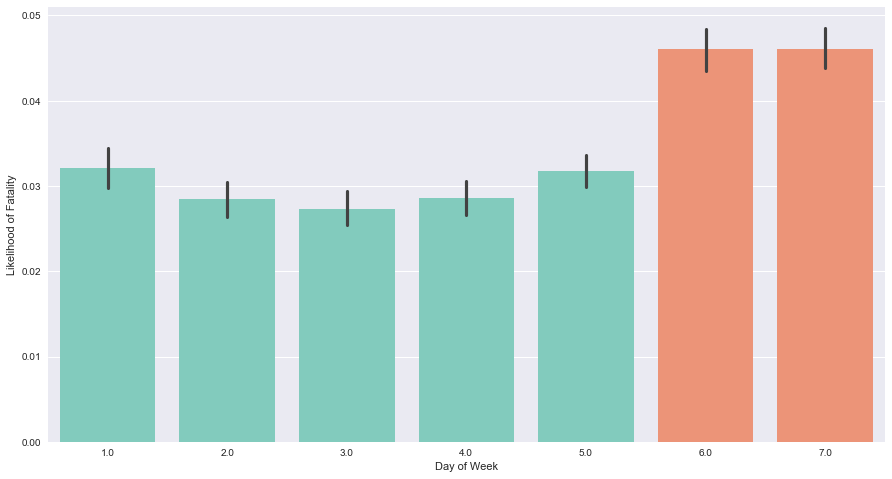

In [403]:
plt.figure(figsize=(15,8))
colors = ['#76D7C4', '#76D7C4', '#76D7C4', '#76D7C4', '#76D7C4', '#FF8A65', '#FF8A65']

ax = sns.barplot(x=df_agecorr.DAY_OF_WEEK, y=df_agecorr.NUMBER_KILLED, palette=colors)
ax.set(xlabel='Day of Week', ylabel='Likelihood of Fatality')

[<matplotlib.text.Text at 0x1a0f2f550>, <matplotlib.text.Text at 0x178082358>]

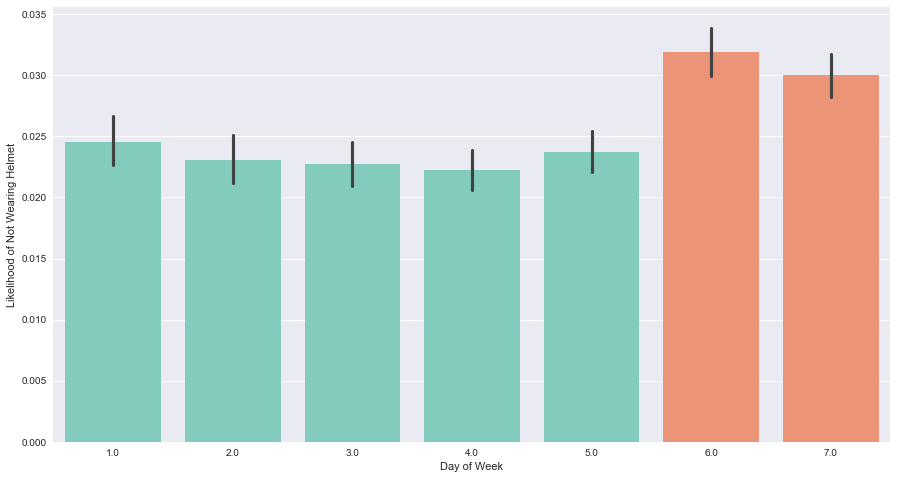

In [419]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=df_agecorr.DAY_OF_WEEK, y=df_agecorr.PARTY_SAFETY_EQUIP_2_V, palette=colors)
ax.set(xlabel='Day of Week', ylabel='Likelihood of Not Wearing Helmet')

[<matplotlib.text.Text at 0x17ee8a0b8>, <matplotlib.text.Text at 0x17ee96320>]

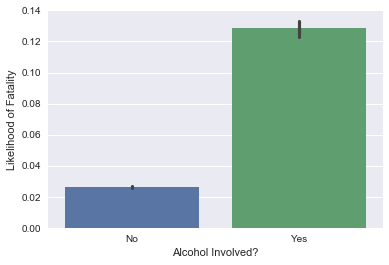

In [455]:
ax = sns.barplot(x=df_agecorr.ALCOHOL_INVOLVED_Y, y=df_agecorr.NUMBER_KILLED)
ax.set(xlabel='Alcohol Involved?', ylabel='Likelihood of Fatality')
ax.set_xticklabels(['No', 'Yes'])
#this speaks, again, to the important difference between using data models to drive decision-making behavior vs
#using data models to predict outcomes: although alcohol_involved doesn't come up terribly highly in the feature
#importances ranking, it clearly does have an impact when you look at class means - see blog writeup for more